# WISE Infilling Example

Example of using proc_continuous to infill an arbitrary masked region of an image. This examples uses a subimage from the WISE 12 um dust map (tile 115).

Requires Julia Kernel

In [1]:
using FITSIO
using StatsBase
using CloudClean
using CairoMakie
using ColorSchemes
using OffsetArrays

# image_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/FilPHANGS_Data/OriginalImages/ngc0628_F770W_JWST_Emission_starsub.fits"
image_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits"
f = FITS(image_path)
raw_image = read(f[1])
header = read_header(f[1])
close(f)
out_image = copy(raw_image);
out_image[isnan.(raw_image)] .= 0.0


0-element view(::Vector{Float64}, Int64[]) with eltype Float64

In [2]:
mask_path = save_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W_JWST_Emission_starsub_Original_source_mask.fits"
# Mask with missing pixels
f = FITS(mask_path)
raw_mask = read(f[1])
close(f)

# Convert the raw mask data into a boolean mask (True for masked pixels, False otherwise)
bimage = raw_mask .!= 0  # Create a boolean mask, True where non-zero

# Now bimage is a boolean array with True for masked pixels and False for unmasked pixels
println("Mask shape: ", size(bimage))

Mask shape: (1891, 2600)


In [3]:
Np = 33
out_image[bimage].= 0
count(bimage)

56177

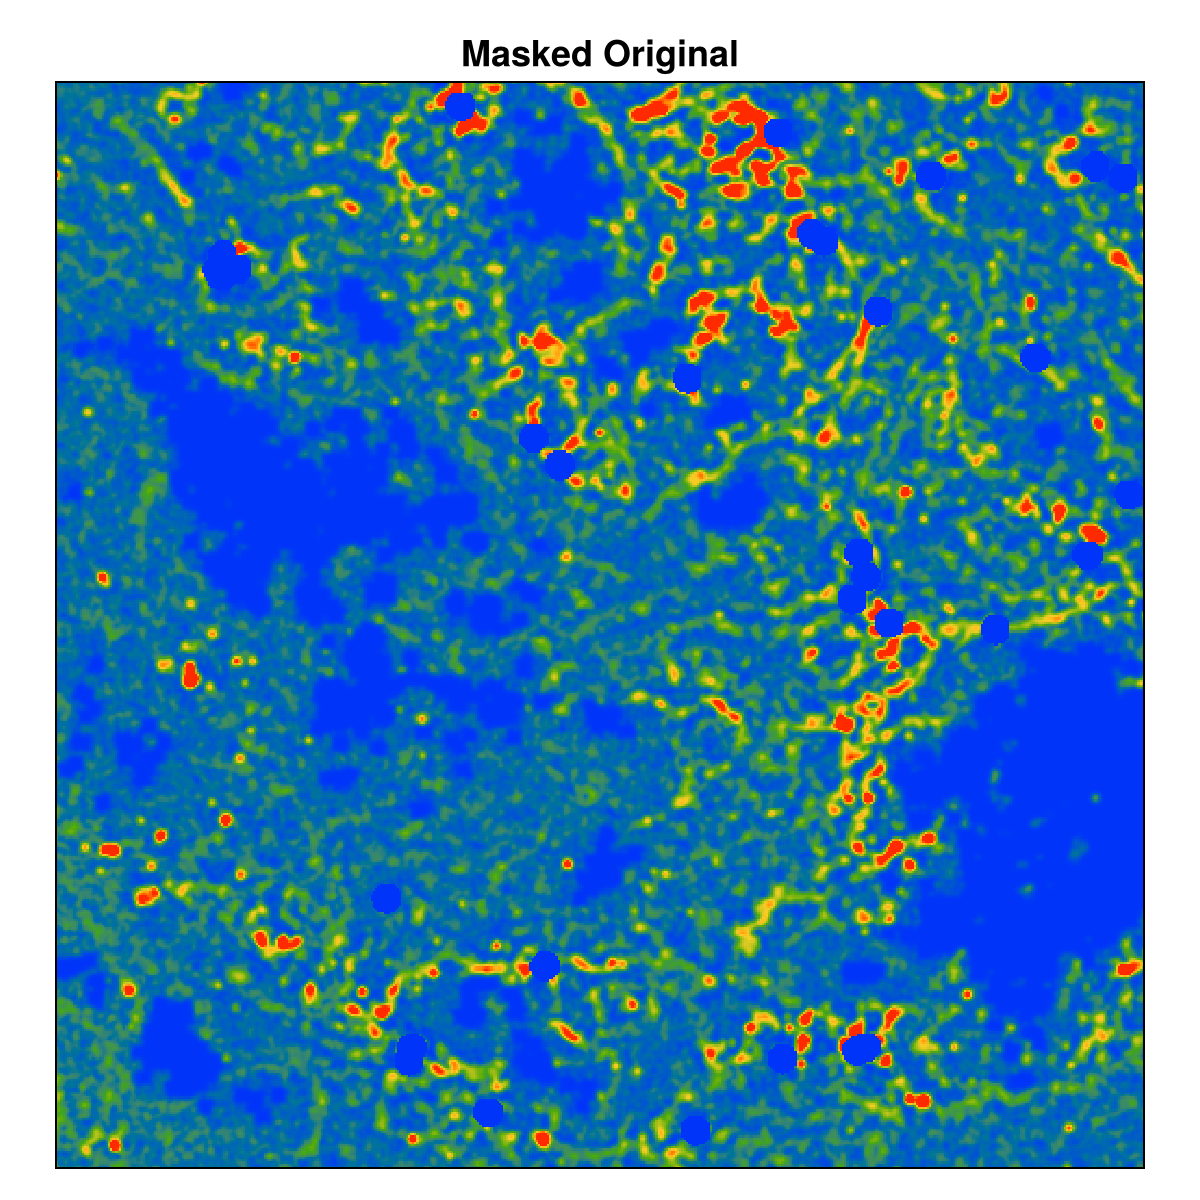

In [4]:
# Example values for cenx, ceny, and dv; adjust these based on your data
cenx = 579
ceny = 579
dv = 250

# Assuming raw_image is your image data and out_image is the image you want to display
# Compute the color range based on percentiles in a region around (cenx, ceny)
vmin, vmax = percentile(out_image[(cenx-dv):(cenx+dv), (ceny-dv):(ceny+dv)], [2, 99])

# Create a figure for plotting
fig = Figure(size=(600, 600), fontsize=18)

# Set up the axis with no ticks or labels
ax = Axis(fig[1,1], aspect=1, title="Masked Original", xticksvisible=false, yticksvisible=false, 
          xticklabelsvisible=false, yticklabelsvisible=false)

# Display the heatmap using the chosen colormap and the computed color range
h = heatmap!(ax, out_image[(cenx-dv):(cenx+dv), (ceny-dv):(ceny+dv)]',
    colormap=:rainbow_bgyr_35_85_c73_n256,
    colorrange=(vmin, vmax)
)

# Resize the figure to fit the layout
resize_to_layout!(fig)

# Show the figure
fig


In [5]:
ndraw0 = 2
widx = 129
x_locs = [cenx]
y_locs = [ceny]
star_stats = proc_continuous(out_image,bimage,Np=Np,tilex=4,ftype=64,widx=widx,seed=2022,ndraw=ndraw0)


# Debug: Check the structure of star_stats
if isa(star_stats, Tuple)
    println("star_stats is a tuple with length: ", length(star_stats))
    for i in 1:length(star_stats)
        println("star_stats[$i] has type: ", typeof(star_stats[i]), " and size: ", size(star_stats[i]))
    end
else
    println("star_stats is not a tuple. It has type: ", typeof(star_stats))
end

Infilling completed after 1 rounds with final width (widx,widy) = (27,27)
Finished 18 of 2816 locations in tile (1, 1)
Finished 29 of 4009 locations in tile (1, 2)
Finished 6 of 869 locations in tile (1, 3)
Finished 0 of 0 locations in tile (1, 4)
Had to use SVD for icov_kgood_kgood at (x,y) = (945,160)
Had to use SVD for sqrt_cov at (x,y) = (945,160)
Finished 14 of 2079 locations in tile (2, 1)
Finished 75 of 11008 locations in tile (2, 2)
Finished 44 of 7231 locations in tile (2, 3)
Finished 12 of 1666 locations in tile (2, 4)
Finished 16 of 2180 locations in tile (3, 1)
Finished 56 of 8899 locations in tile (3, 2)
Finished 46 of 7090 locations in tile (3, 3)
Finished 16 of 2983 locations in tile (3, 4)
Finished 0 of 0 locations in tile (4, 1)
Finished 3 of 420 locations in tile (4, 2)
Finished 27 of 4622 locations in tile (4, 3)
Had to use SVD for icov_kgood_kgood at (x,y) = (1517,2216)
Had to use SVD for sqrt_cov at (x,y) = (1517,2216)
Had to use SVD for icov_kgood_kgood at (x,y) =

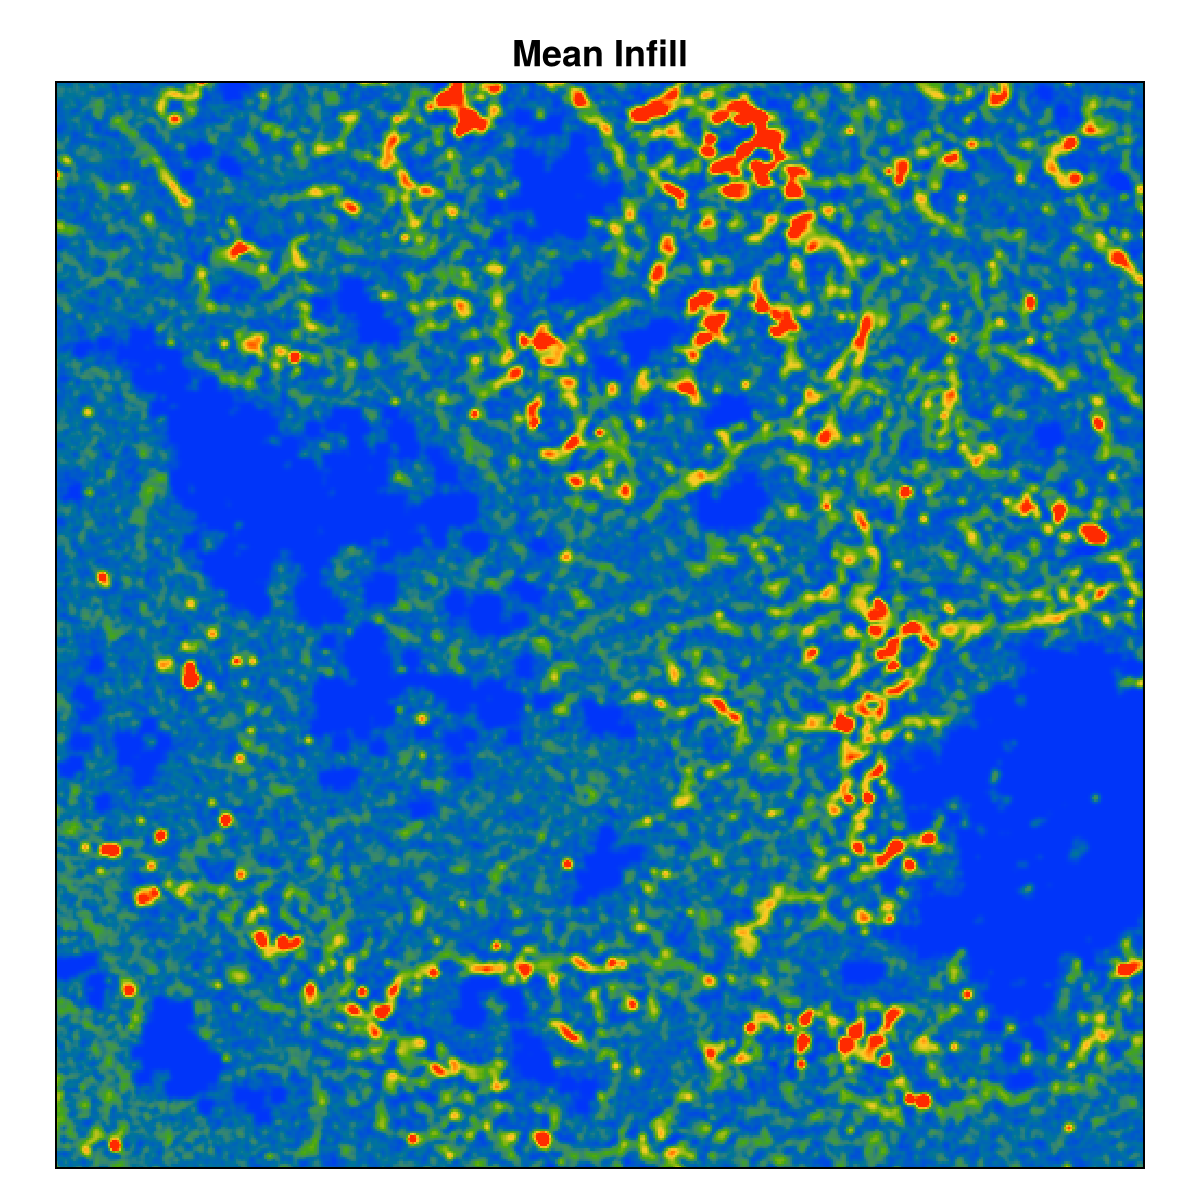

In [6]:
cenx = 579
ceny = 579
dv = 250
vmin, vmax = percentile(out_image[(cenx-dv):(cenx+dv),(ceny-dv):(ceny+dv)],[2,99])
fig = Figure(size=(600, 600), fontsize=18)
ax = Axis(fig[1,1], aspect=1, title="Mean Infill", xticksvisible=false, yticksvisible=false, 
          xticklabelsvisible=false, yticklabelsvisible=false)
h = heatmap!(ax,star_stats[1][(cenx-dv):(cenx+dv),(ceny-dv):(ceny+dv)]',
    colormap=:rainbow_bgyr_35_85_c73_n256,
    colorrange=(vmin,vmax)
)

resize_to_layout!(fig)
fig

In [7]:
dv = 250
fig = Figure(size=(600, 600), fontsize=18)
ax = Axis(fig[1,1], aspect=1, title="Draw Infill", xticksvisible=false, yticksvisible=false, 
          xticklabelsvisible=false, yticklabelsvisible=false)
h = heatmap!(ax,star_stats[2][(cenx-dv):(cenx+dv),(ceny-dv):(ceny+dv),1]',
    colormap=:rainbow_bgyr_35_85_c73_n256,
    colorrange=(vmin,vmax)
)

# Convert to a standard Array
array_data = max.(parent(star_stats[2]), 0)  # Set negative values to zero

# Open a FITS file and write
FITS("ngc0628_drawinfill_16pc_sourceRemovalForSyntheticMaps.fits", "w") do f
    write(f, convert(Array, array_data); header = header)  # Ensure it's a proper Array
end

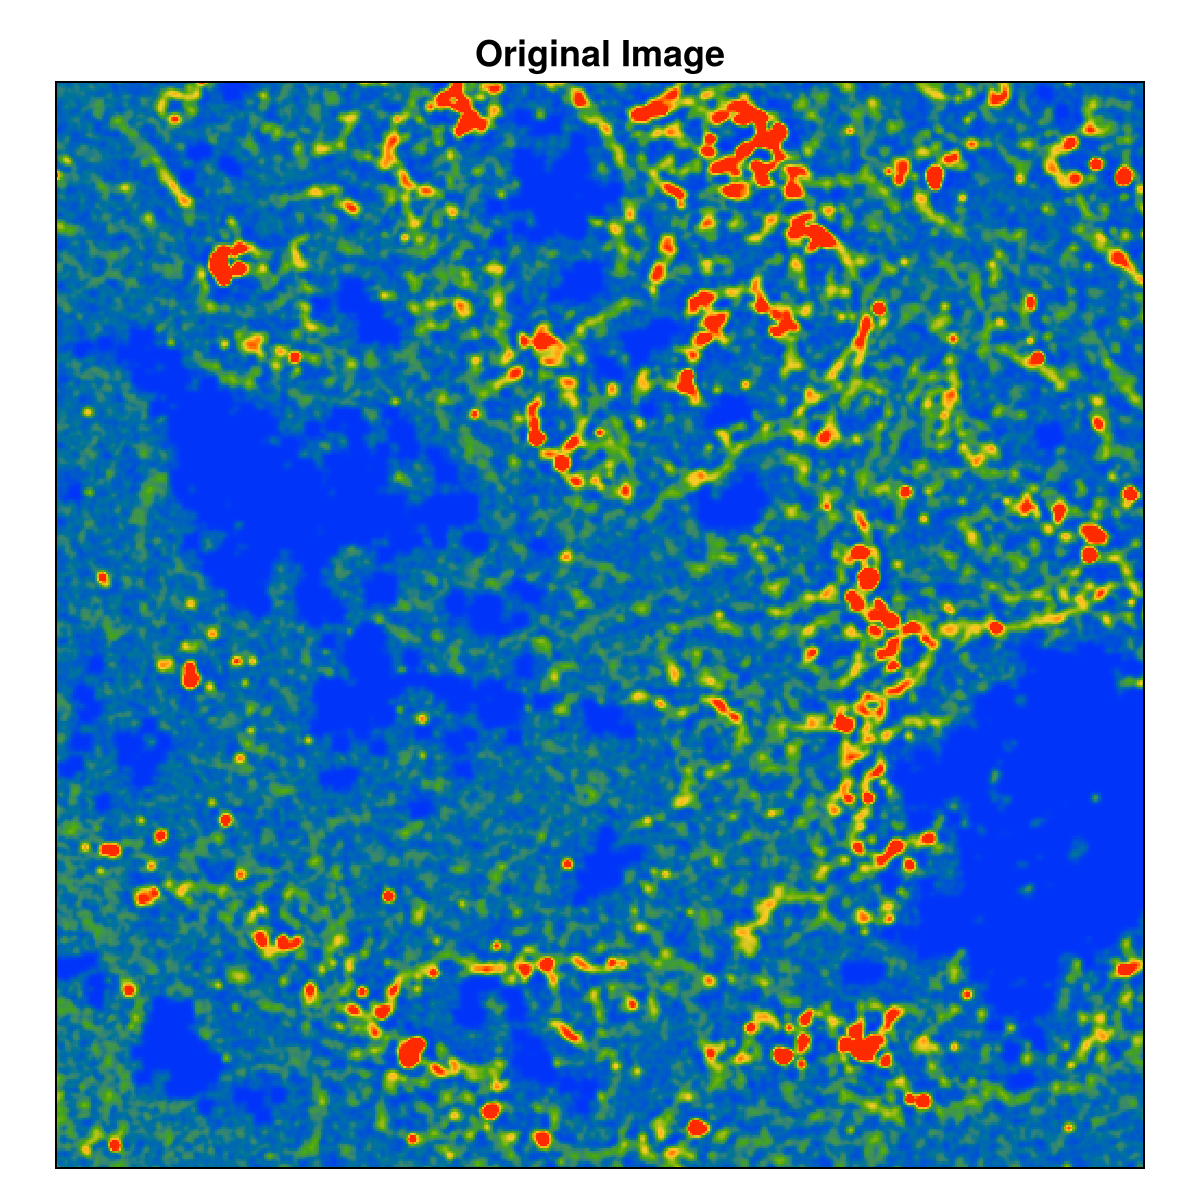

In [8]:
dv = 250
fig = Figure(size=(600, 600), fontsize=18)
ax = Axis(fig[1,1], aspect=1, title="Original Image", xticksvisible=false, yticksvisible=false, 
          xticklabelsvisible=false, yticklabelsvisible=false)
h = heatmap!(ax,raw_image[(cenx-dv):(cenx+dv),(ceny-dv):(ceny+dv)]',
    colormap=:rainbow_bgyr_35_85_c73_n256,
    colorrange=(vmin,vmax)
)

resize_to_layout!(fig)
fig